In [1]:
import pandas as pd
import numpy as np
import os
from mplsoccer.pitch import Pitch

Load event data

In [2]:
df_events_wyscout = pd.read_parquet(os.path.join('..', 'data', 'wyscout', 'event.parquet'))
df_events_statsbomb = pd.read_parquet(os.path.join('..', 'data', 'statsbomb', 'event.parquet'))

Get match dataframe for full seasons in Wyscout data

In [3]:
df_match_wyscout = pd.read_parquet(os.path.join('..', 'data', 'wyscout', 'match.parquet'))
df_match_wyscout = df_match_wyscout[df_match_wyscout.competition_name.isin(['Premier League', 'Ligue 1', 
                                                                            'Bundesliga', 'Serie A', 'La Liga'])].copy()
df_match_wyscout_overlap = pd.read_parquet(os.path.join('..', 'data', 'wyscout', 'match_overlap.parquet'))
df_match_wyscout_overlap = df_match_wyscout_overlap[df_match_wyscout_overlap.competition_name == 'La Liga'].copy()
df_match = pd.concat([df_match_wyscout, df_match_wyscout_overlap])

Get a match dataframe for the overlapping games from the Statsbomb data

In [4]:
df_match_statsbomb = pd.read_parquet(os.path.join('..', 'data', 'statsbomb', 'match.parquet'))
df_match_statsbomb = df_match_statsbomb[(df_match_statsbomb.competition_name == 'La Liga') & 
                                        (df_match_statsbomb.season_name == '2017/2018')].copy()

Get the match id/ team id lookup for overlapping games

In [5]:
cols = ['match_id', 'home_team_id', 'home_team_name', 'away_team_id', 'away_team_name']
df_overlap_ids = df_match_wyscout_overlap[cols].merge(df_match_statsbomb[cols],
                                                      on=['home_team_name', 'away_team_name'], suffixes=['_wyscout', ''])
df_home = df_overlap_ids[['home_team_id_wyscout', 'home_team_id']].copy()
df_away = df_overlap_ids[['away_team_id_wyscout', 'away_team_id']].copy()
df_home.rename({'home_team_id_wyscout': 'team_id_wyscout', 'home_team_id': 'team_id'}, axis=1, inplace=True)
df_away.rename({'away_team_id_wyscout': 'team_id_wyscout', 'away_team_id': 'team_id'}, axis=1, inplace=True)
df_team_overlap = pd.concat([df_home, df_away])
df_team_overlap.drop_duplicates(inplace=True)
df_match_overlap = df_overlap_ids[['match_id', 'match_id_wyscout']]

Add a goal flag

In [6]:
df_events_statsbomb['goal'] = df_events_statsbomb.outcome_name == 'Goal'

# Filter events dataframes to only include shots from the league matches and specific columns

In [7]:
mask_match = df_events_wyscout.match_id.isin(df_match_wyscout.match_id)
mask_shot = df_events_wyscout.subEventName.isin(['Penalty', 'Free kick shot', 'Shot'])
cols = ['match_id', 'id', 'subEventName', 'matchPeriod', 'eventSec', 'team_id', 'x', 'y', 'goal']
df_events_wyscout = df_events_wyscout.loc[mask_match & mask_shot, cols].copy()

In [8]:
mask_match = df_events_statsbomb.match_id.isin(df_match_statsbomb.match_id)
mask_shot = df_events_statsbomb.type_name == 'Shot'
cols = ['match_id', 'id', 'period', 'timestamp_minute', 'timestamp_second', 'timestamp_millisecond',
        'team_id', 'x', 'y', 'shot_statsbomb_xg', 'goal']
df_events_statsbomb = df_events_statsbomb.loc[mask_match & mask_shot, cols].copy()

Add wyscout match/ team ids to statsbomb data

In [9]:
df_events_statsbomb = df_events_statsbomb.merge(df_match_overlap)
df_events_statsbomb = df_events_statsbomb.merge(df_team_overlap)
df_events_statsbomb.drop('match_id', axis=1, inplace=True)
df_events_statsbomb.drop('team_id', axis=1, inplace=True)
df_events_statsbomb = df_events_statsbomb.rename({'match_id_wyscout': 'match_id', 'team_id_wyscout': 'team_id'}, axis=1)

Add on wyscout xg

In [10]:
df_xg = pd.read_parquet(os.path.join('..', 'data', 'modelling', 'xg_shap.parquet'))
df_xg = df_xg.loc[df_xg.wyscout_id.notnull(), ['match_id', 'wyscout_id', 'xg']].rename({'wyscout_id': 'id'}, axis=1)
df_events_wyscout = df_events_wyscout.merge(df_xg, on=['match_id', 'id'], how='left')
df_events_wyscout.loc[df_events_wyscout.subEventName == 'Penalty', 'xg'] = 0.76

Do not have xg for some outliers

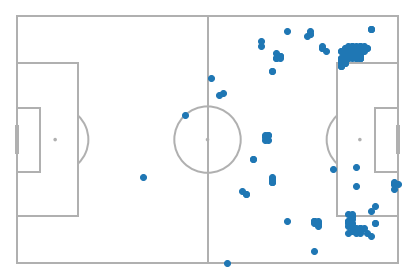

In [11]:
pitch = Pitch(pitch_type='wyscout')
fig, ax = pitch.draw()
mask_no_xg = df_events_wyscout.xg.isnull()
pitch.scatter(df_events_wyscout[mask_no_xg].x, df_events_wyscout[mask_no_xg].y, ax=ax)

Set xg to 0.015 if missing (1.5%)

In [12]:
df_events_wyscout.loc[df_events_wyscout.xg.isnull(), 'xg'] = 0.015

Tidy up dataframes for consistent formats

In [13]:
df_events_statsbomb['eventSec'] = (df_events_statsbomb.timestamp_minute * 60 +
                                   df_events_statsbomb.timestamp_second +
                                   df_events_statsbomb.timestamp_millisecond / 1000.)
df_events_statsbomb.rename({'shot_statsbomb_xg': 'xg'}, axis=1, inplace=True)
df_events_statsbomb.drop(['timestamp_minute', 'timestamp_second', 'timestamp_millisecond'], axis=1, inplace=True)

In [14]:
df_events_wyscout.rename({'matchPeriod': 'period'}, axis=1, inplace=True)
df_events_wyscout['period'] = df_events_wyscout.period.map({'1H': 1, '2H': 2})

Combine the dataframes

In [15]:
df_events_wyscout['data'] = 'wyscout'
df_events_statsbomb['data'] = 'statsbomb'
df_events = pd.concat([df_events_wyscout, df_events_statsbomb])

Sort the dataframe

In [16]:
df_events.sort_values(['match_id', 'period', 'eventSec'], inplace=True)

# Create a shot possession group (i.e. shots within 15 seconds of each other are in the same group)

In [17]:
df_events['eventSec_shift'] = df_events.groupby(['match_id', 'period']).eventSec.shift(1)
df_events['new_shot_sequence'] = (((df_events['eventSec'] - df_events['eventSec_shift']) > 15) |
                                  (df_events.match_id != df_events.match_id.shift(1)) |
                                  (df_events.period != df_events.period.shift(1)))
df_events['possession'] = df_events.new_shot_sequence.cumsum()
df_events.drop(['eventSec_shift', 'new_shot_sequence'], axis=1, inplace=True)

# Set random seed

In [18]:
np.random.seed(42)

# Set number of simulations

In [19]:
n_sims = 10000

# Add a home_or_away column to the events dataframe:
home_shots when the shot is taken by the home team <br>
away_shots when the shot is taken by the away team

In [20]:
# first merge on the the home_team_id for each match from the df_match dataframe
df_events = df_events.merge(df_match[['match_id','home_team_id']],on='match_id',validate='m:1',how='left')
# then create a home_or_away column by comparing the home_team_id with the team_id
mask_home = df_events.team_id == df_events.home_team_id
df_events['home_or_away'] = np.where(mask_home,'home_shots','away_shots')
df_events.drop('home_team_id',axis=1,inplace=True)

# Show matches where one team didn't get a single shot on target.

In [21]:
# group on match id and show matches wher there is only one team with a shot event
num_teams_per_match = df_events.groupby('match_id').team_id.nunique()
num_teams_per_match[num_teams_per_match==1].index.tolist()

[2500013, 2576281]

# We are going to make the analysis easier by adding a fake shot with 0xG where the team didn't get a shot on target

Note for the purpose of the simulation 0xG will mean that the fake shot will never count as a goal. As the xG value will be lower than the simulated proability.

In [22]:
len(df_events)

43091

In [23]:
# first we merge the number of shots for each team on to the df_match dataframe
df_shots_per_team = (df_events.groupby(['match_id','home_or_away']).team_id.count()
                     .reset_index()
                     .pivot(index='match_id',columns='home_or_away',values='team_id')
                     .reset_index()
                     .fillna(0))
df_match = df_match.merge(df_shots_per_team,on='match_id',how='left',validate='1:1')
# next we merge the maximum possession on to the df_match
df_max_possession = (df_events.groupby('match_id').possession.max()).reset_index()
df_match = df_match.merge(df_max_possession,on='match_id',how='left',validate='1:1')
# we create a fake shot record for each match where the away team has no shots
df_away_missing =  df_match.loc[df_match.away_shots==0,['match_id','possession','away_team_id']].copy()
df_away_missing['xg'] = 0.0
df_away_missing['home_or_away'] = 'away_shots'
df_away_missing.rename({'away_team_id':'team_id'},axis=1,inplace=True)
# we also create a fake shot record where the home team has no shots
df_home_missing = df_match.loc[df_match.home_shots==0,['match_id','possession','home_team_id']].copy()
df_home_missing['xg'] = 0.0
df_home_missing['home_or_away'] = 'home_shots'
df_home_missing.rename({'home_team_id':'team_id'},axis=1,inplace=True)
# combine the missing shot information and add one to the max possession to make it unique
df_missing_shots = pd.concat([df_home_missing,df_away_missing],axis=0)
df_missing_shots['possession'] = df_missing_shots.possession + 1
# add the fake shot data to the event dataframe and sort it into the right order
df_events = pd.concat([df_missing_shots,df_events])
df_events.sort_values(['match_id','possession'],inplace=True)

In [24]:
len(df_events)

43093

# Remake possession now we have added a few fake shots

In [25]:
# group by the match and possession number and give it a unique id
df_events['possession_shot_id'] = df_events.groupby(['match_id','possession']).ngroup()

# Show events where the possession has more than one team shooting

There a few shot sequences where more than one team has a shot. This impacts our simulation. If there is a goal, I want to model it so the rest of the possession didn't happen and the second team didn't have a chance to shoot. This is to mimic a real match where if one team scores, there is a kick-off and the possession ends.

In [26]:
num_teams_per_possession_sequence = df_events.groupby('possession_shot_id').team_id.nunique()
num_teams_per_possession_sequence[num_teams_per_possession_sequence>1].index

Int64Index([  336,  1188,  2582,  3008,  3122,  3182,  4380,  4524,  6201,
             6318,  6787,  7525,  8148,  8456,  9065,  9205,  9293,  9402,
            10239, 10904, 11243, 11774, 12505, 13072, 15344, 15559, 16079,
            17936, 18084, 18338, 18372, 18667, 19155, 19341, 19344, 19698,
            20083, 20326, 20764, 22794, 22877, 23563, 23917, 23990, 24293,
            24588, 24837, 24887, 25342, 25640, 25665, 26906, 28213, 28499,
            28918, 29061, 30419, 30673, 30693, 31218, 32109, 33482, 34530,
            34552, 34824, 35110, 36796, 36910, 36997, 38273, 39619],
           dtype='int64', name='possession_shot_id')

# Simulate the goals for each shot and sum up the number of goals for each team in a match

First simulate the goals. We are going to create an array of uniform random numbers between 0-1. If the random number is greater than the xG we do not count it as a goal (=0). If the random number is less than the xG we count it as a goal (=1). For example, for a shot with xG of 0.17 then there is a 17% chance of a goal, we count it as a goal if the random number is <= 0.17.

In [27]:
n_shots = len(df_events)
simulated_probabilities = np.random.uniform(size=(n_shots, n_sims))
simulated_goals = np.where(simulated_probabilities > df_events.xg.values.reshape(-1, 1), 0, 1)

In [28]:
simulated_goals.shape

(43093, 10000)

Create a dataframe of simulated goals and if there is more than one simulated goal in a unique possession keep the first and set the others to zero. The dataframe is n_shots length by n_sims wide.

In [29]:
df_simulated_goals = pd.concat([df_events[['possession_shot_id']],
                                pd.DataFrame(simulated_goals,index=df_events.index)],
                               axis=1)
# here we are setting the first goal in the possession to 1 and the rest of the goals in the possession to 0
df_simulated_goals = df_simulated_goals.groupby('possession_shot_id').cumsum()
df_simulated_goals = pd.DataFrame(np.where(df_simulated_goals>1, 0, df_simulated_goals), index=df_events.index)

In [30]:
df_simulated_goals.shape

(43093, 10000)

Next we sum the number of simulated goals for each team in the match. The dataframe is now (n_teams*2) length by n_sims wide

In [31]:
# we add on the match id and home_or_away flag and sum the goals in the game for each team (home_shots/ away_shots)
df_simulated_goals = pd.concat([df_events[['match_id','home_or_away']], df_simulated_goals],axis=1)
df_simulated_goals = df_simulated_goals.groupby(['match_id','home_or_away'])[df_simulated_goals.columns[2:]].sum()
df_simulated_goals.reset_index(inplace=True)

In [32]:
df_simulated_goals.shape

(3652, 10002)

# Calculate the winning probabilities and add to the df_match dataframe

In [33]:
# first create a seperate dataframe for the home and away scores
# we first set the index to the match id so when we split the home and away dataframes have the same index
df_simulated_goals.set_index('match_id',inplace=True)
mask_home = df_simulated_goals.home_or_away=='home_shots'

In [34]:
df_goals_home = df_simulated_goals.loc[mask_home,df_simulated_goals.columns[1:]]
df_goals_away = df_simulated_goals.loc[~mask_home,df_simulated_goals.columns[1:]]
# then compare them and calculate percentages/probabilities for each game state
home_win = (df_goals_home > df_goals_away).mean(axis=1)
away_win = (df_goals_away > df_goals_home).mean(axis=1)
draw = (df_goals_home == df_goals_away).mean(axis=1)
df_probabilities = pd.concat([home_win,away_win,draw],axis=1)
df_probabilities.columns = ['home_win','away_win','draw']
df_probabilities.reset_index(inplace=True)
df_match = df_match.merge(df_probabilities,on='match_id',how='left',validate='1:1')

# Calculate the average points and add to the df_match dataframe.

In [35]:
df_match['away_points_sim'] = (df_match.away_win * 3 + df_match.draw)
df_match['home_points_sim'] = (df_match.home_win * 3 + df_match.draw)

# Add the goal difference, e.g. the probability that the home team is -5 goals down to the df_match dataframe

In [36]:
# first get the goal difference in relation to the home team
df_goal_diff = df_goals_home.subtract(df_goals_away).reset_index()
# then create counts of the goal differences. n_matches length * n_categories of goal difference wide
df_goal_diff_counts = (df_goal_diff.melt(id_vars='match_id',value_name='home_goal_difference')
                       .groupby('match_id')
                       .home_goal_difference.value_counts())
df_goal_diff_counts.name = 'counts'
df_goal_diff_counts = df_goal_diff_counts.reset_index()
df_goal_diff_counts = df_goal_diff_counts.pivot(index='match_id',columns='home_goal_difference',values='counts')
df_goal_diff_counts.fillna(0,inplace=True)
# summarise the counts so we get one category for -5 and under and one for 6 and over
cols_minus_5_and_under = df_goal_diff_counts.columns[df_goal_diff_counts.columns <= -5]
counts_minus_5_and_under = df_goal_diff_counts[cols_minus_5_and_under].sum(axis=1)
counts_minus_5_and_under.name = 'home_goal_diff_minus_5_or_fewer'
cols_6_and_over = df_goal_diff_counts.columns[df_goal_diff_counts.columns >= 6]
counts_six_and_over = df_goal_diff_counts[cols_6_and_over].sum(axis=1)
counts_six_and_over.name = 'home_goal_diff_6_or_greater'
other_cols = sorted(set(df_goal_diff_counts.columns) - set(cols_minus_5_and_under) - set(cols_6_and_over))
counts_other = df_goal_diff_counts[other_cols]
new_cols = ['home_goal_diff_'+str(col).replace('-','minus_') for col in counts_other.columns]
counts_other.columns = new_cols
df_goal_diff_counts = pd.concat([counts_minus_5_and_under,counts_other,counts_six_and_over],axis=1)
# calculate percentages by dividing by the number of simulations
df_goal_diff_percentage = (df_goal_diff_counts / n_sims)
df_goal_diff_percentage.reset_index(inplace=True)
# add the goal difference proabilities to the dataframe
df_match = df_match.merge(df_goal_diff_percentage,on='match_id',how='left',validate='1:1')

# Add the actual home/away points to the df_match dataframe

In [37]:
mask_home_win = df_match.home_score > df_match.away_score
mask_away_win = df_match.away_score > df_match.home_score
mask_draw = df_match.away_score == df_match.home_score
df_match.loc[mask_home_win,'home_points'] = 3
df_match.loc[mask_home_win,'away_points'] = 0
df_match.loc[mask_away_win,'away_points'] = 3
df_match.loc[mask_away_win,'home_points'] = 0
df_match.loc[mask_draw,'home_points'] = 1
df_match.loc[mask_draw,'away_points'] = 1

# Recreate the League Tables

In [38]:
# create some columns used to create the table stats: goal difference, win, lose, draw
df_match['home_goal_diff'] = df_match['home_score'] - df_match['away_score']
df_match['home_win'] = df_match.home_score > df_match.away_score
df_match['home_lose'] = df_match.home_score < df_match.away_score
df_match['away_goal_diff'] = df_match['away_score'] - df_match['home_score']
df_match['away_win'] = df_match.away_score > df_match.home_score
df_match['away_lose'] = df_match.away_score < df_match.home_score
df_match['draw'] = df_match.away_score == df_match.home_score

In [39]:
df_match.competition_name.value_counts()

La Liga           380
Premier League    380
Ligue 1           380
Serie A           380
Bundesliga        306
Name: competition_name, dtype: int64

In [40]:
league_tables = []
for competition in ['Premier League', 'Ligue 1', 'Bundesliga', 'Serie A', 'La Liga']:
    match_ids = df_match[(df_match.competition_name==competition)].match_id
    # create a dataframe of away results
    away_cols = ['away_team_name','away_points','away_goal_diff','away_win','draw',
                 'away_lose','away_score','home_score']
    away_rename = {'away_points':'points','away_team_name':'team_name',
                   'away_goal_diff':'goal_difference','away_win':'win','away_lose':'lose',
                   'away_score':'goals_for','home_score':'goals_against'}
    df_away = df_match.loc[df_match.match_id.isin(match_ids), away_cols]
    # create a dataframe of home results
    home_cols = ['home_team_name','home_points','home_goal_diff','home_win','draw','home_lose',
                 'home_score','away_score']
    home_rename = {'home_points':'points','home_team_name':'team_name',
                   'home_goal_diff':'goal_difference','home_win':'win','home_lose':'lose',
                   'home_score':'goals_for','away_score':'goals_against'}
    df_home = df_match.loc[df_match.match_id.isin(match_ids),home_cols]
    # combine to get the whole league results
    df_league = pd.concat([df_away.rename(away_rename,axis=1),
                           df_home.rename(home_rename,axis=1)])
    # add the number of games played to the team stats to create a df_table dataframe
    stats_cols = ['win','draw','lose','goals_for','goals_against','goal_difference','points']
    df_table = (df_league.groupby('team_name')[stats_cols].sum())
    df_played = df_league.team_name.value_counts()
    df_played.name = 'played'
    df_table = pd.concat([df_played, df_table],axis=1,sort=False)
    # sort by the criteria for winning league, note there is one final criteria head-for-head not implemented here
    df_table.sort_values(['points','goal_difference','goals_for','win'],ascending=False,inplace=True)
    # index as team rank rather than team name
    df_table.reset_index(inplace=True)
    df_table.index = df_table.index+1
    # set columns to easy names
    df_table.columns = ['Team','Played','Won','Drawn','Lost','For','Against','Goal Difference','Points']
    # columns to integers (some are float)
    df_table[df_table.columns[1:]] = df_table[df_table.columns[1:]].astype(int)   
    # add position to dataframe
    df_table.index.name = 'position'
    df_table.reset_index(inplace=True)
    league_tables.append(df_table)

In La liga and seria A. The fules for classification are different 1) Points; 2) Head-to-head points; 3) Head-to-head goal difference; 4) Goal difference; 5) Goals scored

I.e. head to head results get considered before goal difference so the tables are in the wrong order.

Manually set them in the right order

In [41]:
df_spain = league_tables[4]
df_spain.loc[df_spain.Team == 'Espanyol', 'position'] = 11
df_spain.loc[df_spain.Team == 'Real Sociedad', 'position'] = 12
df_spain.loc[df_spain.Team == 'Celta Vigo', 'position'] = 13
df_spain.sort_values('position', inplace=True)
league_tables[4] = df_spain

In [42]:
df_italy = league_tables[3]
df_italy.loc[df_italy.Team == 'FC Internazionale Milano', 'position'] = 4
df_italy.loc[df_italy.Team == 'SS Lazio', 'position'] = 5
df_italy.loc[df_italy.Team == 'AC Chievo Verona', 'position'] = 13
df_italy.loc[df_italy.Team == 'Udinese Calcio', 'position'] = 14
df_italy.sort_values('position', inplace=True)
league_tables[3] = df_italy

In [43]:
league_tables[0]

,position,Team,Played,Won,Drawn,Lost,For,Against,Goal Difference,Points
0,1,Manchester City,38,32,4,2,106,27,79,100
1,2,Manchester United,38,25,6,7,68,28,40,81
2,3,Tottenham Hotspur,38,23,8,7,74,36,38,77
3,4,Liverpool,38,21,12,5,84,38,46,75
4,5,Chelsea,38,21,7,10,62,38,24,70
5,6,Arsenal,38,19,6,13,74,51,23,63
6,7,Burnley FC,38,14,12,12,36,39,-3,54
7,8,Everton,38,13,10,15,44,58,-14,49
8,9,Leicester City,38,12,11,15,56,60,-4,47
9,10,Newcastle United,38,12,8,18,39,47,-8,44


In [44]:
league_tables[1]

,position,Team,Played,Won,Drawn,Lost,For,Against,Goal Difference,Points
0,1,Paris Saint-Germain FC,38,29,6,3,108,29,79,93
1,2,AS Monaco,38,24,8,6,85,45,40,80
2,3,Olympique Lyonnais,38,23,9,6,87,43,44,78
3,4,Olympique de Marseille,38,22,11,5,80,47,33,77
4,5,Stade Rennais FC,38,16,10,12,50,44,6,58
5,6,FC Girondins de Bordeaux,38,16,7,15,53,48,5,55
6,7,AS Saint-Étienne,38,15,10,13,47,50,-3,55
7,8,O.G.C. Nice Côte d'Azur,38,15,9,14,53,52,1,54
8,9,FC Nantes,38,14,10,14,36,41,-5,52
9,10,Montpellier HSC,38,11,18,9,36,33,3,51


In [45]:
league_tables[2]

,position,Team,Played,Won,Drawn,Lost,For,Against,Goal Difference,Points
0,1,FC Bayern München,34,27,3,4,92,28,64,84
1,2,FC Schalke 04,34,18,9,7,53,37,16,63
2,3,TSG 1899 Hoffenheim,34,15,10,9,66,48,18,55
3,4,Borussia Dortmund,34,15,10,9,64,47,17,55
4,5,TSV Bayer 04 Leverkusen,34,15,10,9,58,44,14,55
5,6,Rasen Ballsport Leipzig,34,15,8,11,57,53,4,53
6,7,VfB Stuttgart 1893,34,15,6,13,36,36,0,51
7,8,Eintracht Frankfurt,34,14,7,13,45,45,0,49
8,9,Borussia VfL Mönchengladbach,34,13,8,13,47,52,-5,47
9,10,Hertha BSC,34,10,13,11,43,46,-3,43


In [46]:
league_tables[3]

,position,Team,Played,Won,Drawn,Lost,For,Against,Goal Difference,Points
0,1,Juventus,38,30,5,3,86,24,62,95
1,2,SSC Napoli,38,28,7,3,77,29,48,91
2,3,AS Roma,38,23,8,7,61,28,33,77
4,4,FC Internazionale Milano,38,20,12,6,66,30,36,72
3,5,SS Lazio,38,21,9,8,89,49,40,72
5,6,AC Milan,38,18,10,10,56,42,14,64
6,7,Atalanta Bergamasca Calcio,38,16,12,10,57,39,18,60
7,8,ACF Fiorentina,38,16,9,13,54,46,8,57
8,9,Torino FC,38,13,15,10,54,46,8,54
9,10,UC Sampdoria,38,16,6,16,56,60,-4,54


In [47]:
league_tables[4]

,position,Team,Played,Won,Drawn,Lost,For,Against,Goal Difference,Points
0,1,Barcelona,38,28,9,1,99,29,70,93
1,2,Atlético Madrid,38,23,10,5,58,22,36,79
2,3,Real Madrid,38,22,10,6,94,44,50,76
3,4,Valencia,38,22,7,9,65,38,27,73
4,5,Villarreal,38,18,7,13,57,50,7,61
5,6,Real Betis,38,18,6,14,60,61,-1,60
6,7,Sevilla,38,17,7,14,49,58,-9,58
7,8,Getafe,38,15,10,13,42,33,9,55
8,9,Eibar,38,14,9,15,44,50,-6,51
9,10,Girona,38,14,9,15,50,59,-9,51


# Simuate the league points

In [48]:
home_win = (df_goals_home > df_goals_away)
away_win = (df_goals_away > df_goals_home)
draw = (df_goals_home == df_goals_away)

In [49]:
home_win = home_win.merge(df_match[['match_id', 'home_team_name', 'competition_name']],
                          left_index=True, right_on='match_id').rename({'home_team_name': 'team_name'}, axis=1)

In [50]:
draw1 = draw.merge(df_match[['match_id', 'home_team_name', 'competition_name']],
                   left_index=True, right_on='match_id').rename({'home_team_name': 'team_name'}, axis=1)

In [51]:
away_win = away_win.merge(df_match[['match_id', 'away_team_name', 'competition_name']],
                          left_index=True, right_on='match_id').rename({'away_team_name': 'team_name'}, axis=1)

In [52]:
draw2 = draw.merge(df_match[['match_id', 'away_team_name', 'competition_name']],
                   left_index=True, right_on='match_id').rename({'away_team_name': 'team_name'}, axis=1)

In [53]:
cols = home_win.columns[:-3]
points_home = home_win.groupby(['team_name', 'competition_name'])[cols].sum() * 3
points_away = away_win.groupby(['team_name', 'competition_name'])[cols].sum() * 3
points_draw1 = draw1.groupby(['team_name', 'competition_name'])[cols].sum()
points_draw2 = draw2.groupby(['team_name', 'competition_name'])[cols].sum()

In [54]:
all_points = points_home + points_away + points_draw1 + points_draw2
all_points.reset_index(inplace=True)

In [55]:
league_sims_points = []
for i, league in enumerate(['Premier League', 'Ligue 1', 'Bundesliga', 'Serie A', 'La Liga']):
    df_league_actual = league_tables[i]
    df_league_points = (all_points[all_points.competition_name == league]
                        .drop('competition_name', axis=1))
    df_league_points = df_league_points.merge(df_league_actual[['Team', 'position']],
                                              left_on='team_name', right_on='Team', how='left')
    df_league_points.sort_values('position', inplace=True)
    df_league_points.drop(['Team', 'position'], axis=1, inplace=True)
    df_league_points.set_index('team_name', inplace=True)
    league_sims_points.append(df_league_points)

In [56]:
df_goals_home = df_goals_home.merge(df_match[['match_id', 'home_team_name', 'competition_name']],
                                    left_index=True, right_on='match_id').rename({'home_team_name': 'team_name'}, axis=1)

In [57]:
df_goals_away = df_goals_away.merge(df_match[['match_id', 'away_team_name', 'competition_name']],
                                    left_index=True, right_on='match_id').rename({'away_team_name': 'team_name'}, axis=1)

In [58]:
df_home_gd = df_goals_home[cols] - df_goals_away[cols]
df_away_gd = df_goals_away[cols] - df_goals_home[cols]

In [59]:
df_home_gd = pd.concat([df_goals_home[['team_name', 'competition_name']], df_home_gd], axis=1)
df_away_gd = pd.concat([df_goals_away[['team_name', 'competition_name']], df_away_gd], axis=1)

In [60]:
df_home_gd = df_home_gd.groupby(['team_name', 'competition_name'])[cols].sum()

In [61]:
df_away_gd = df_away_gd.groupby(['team_name', 'competition_name'])[cols].sum()

In [62]:
df_gd = df_home_gd + df_away_gd

In [63]:
df_gd.reset_index(inplace=True)

In [64]:
league_sims_gd = []
for i, league in enumerate(['Premier League', 'Ligue 1', 'Bundesliga', 'Serie A', 'La Liga']):
    df_league_actual = league_tables[i]
    df_league_gd = (df_gd[df_gd.competition_name == league]
                    .drop('competition_name', axis=1))
    df_league_gd = df_league_gd.merge(df_league_actual[['Team', 'position']],
                                      left_on='team_name', right_on='Team', how='left')
    df_league_gd.sort_values('position', inplace=True)
    df_league_gd.drop(['Team', 'position'], axis=1, inplace=True)
    df_league_gd.set_index('team_name', inplace=True)
    league_sims_gd.append(df_league_gd)

In [65]:
with pd.ExcelWriter(os.path.join('figures', 'simulated_league_table.xlsx')) as writer: 
    sim_position = []
    for i, competition in enumerate(league_sims_points):
        df_pos = competition.rank(axis=0, ascending=False, method='first').T
        df_pos = df_pos.apply(pd.Series.value_counts)
        df_pos.fillna(0, inplace=True)
        df_pos = np.round(df_pos / 100, 0).astype(np.int32)
        df_pos.index.name = 'position'
        df_pos = df_pos.T
        df_pos.columns = list(range(1, len(df_pos.columns) + 1))
        df_pos.index.name = ''
        df_pos = df_pos.style.background_gradient(cmap='viridis')
        name = ['premier_league', 'ligue_1', 'bundesliga', 'serie_a', 'la_liga'][i]
        df_pos.to_excel(writer, sheet_name=name)
        sim_position.append(df_pos)

In [66]:
sim_position[0]

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
,,,,,,,,,,,,,,,,,,,,
Manchester City,90,8,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Manchester United,0,3,11,19,22,19,12,6,4,2,1,0,0,0,0,0,0,0,0,0
Tottenham Hotspur,2,25,38,19,9,5,2,1,0,0,0,0,0,0,0,0,0,0,0,0
Liverpool,7,56,23,9,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Chelsea,0,3,11,21,22,20,12,6,3,2,1,0,0,0,0,0,0,0,0,0
Arsenal,0,4,13,23,23,17,10,5,2,1,1,0,0,0,0,0,0,0,0,0
Burnley FC,0,0,0,0,0,0,1,3,5,6,7,8,9,10,10,10,10,8,7,4
Everton,0,0,0,0,1,3,6,9,11,11,12,10,9,8,6,5,4,3,2,1
Leicester City,0,0,0,2,4,7,13,15,14,12,9,7,5,4,3,2,1,1,0,0


In [67]:
sim_position[1]

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
,,,,,,,,,,,,,,,,,,,,
Paris Saint-Germain FC,90,9,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AS Monaco,0,5,12,18,15,12,10,8,6,5,3,3,2,1,1,0,0,0,0,0
Olympique Lyonnais,4,33,32,14,7,4,2,1,1,1,0,0,0,0,0,0,0,0,0,0
Olympique de Marseille,7,44,28,11,5,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0
Stade Rennais FC,0,1,3,7,9,9,9,9,9,8,7,7,6,5,4,3,2,1,0,0
FC Girondins de Bordeaux,0,3,8,14,14,12,10,8,7,6,5,4,3,2,2,1,1,0,0,0
AS Saint-Étienne,0,1,2,5,6,8,9,9,9,9,8,8,7,6,5,4,2,2,1,0
O.G.C. Nice Côte d'Azur,0,1,4,7,10,10,9,9,9,8,8,6,5,4,3,2,1,1,0,0
FC Nantes,0,1,3,7,9,10,10,9,8,8,8,7,6,5,4,3,2,1,0,0


In [68]:
sim_position[2]

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
,,,,,,,,,,,,,,,,,,
FC Bayern München,73,20,6,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
FC Schalke 04,0,2,5,10,13,12,11,9,8,7,6,5,4,3,2,2,1,0
TSG 1899 Hoffenheim,1,5,11,20,16,13,9,7,5,4,3,2,1,1,1,0,0,0
Borussia Dortmund,14,38,27,11,5,3,1,1,0,0,0,0,0,0,0,0,0,0
TSV Bayer 04 Leverkusen,11,30,34,13,6,4,2,1,0,0,0,0,0,0,0,0,0,0
Rasen Ballsport Leipzig,1,3,9,18,17,13,10,8,6,4,4,3,2,1,1,0,0,0
VfB Stuttgart 1893,0,0,1,4,7,8,10,10,10,9,8,8,7,6,5,4,2,1
Eintracht Frankfurt,0,1,4,8,11,11,11,10,9,7,7,6,5,4,3,2,1,1
Borussia VfL Mönchengladbach,0,0,1,4,5,7,8,8,9,9,8,8,7,7,6,6,4,3


In [69]:
sim_position[3]

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
,,,,,,,,,,,,,,,,,,,,
Juventus,12,18,18,16,13,10,7,4,2,1,0,0,0,0,0,0,0,0,0,0
SSC Napoli,51,23,13,6,4,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0
AS Roma,6,13,16,17,15,12,9,6,3,1,1,0,0,0,0,0,0,0,0,0
FC Internazionale Milano,4,8,12,14,15,15,13,9,6,3,1,1,0,0,0,0,0,0,0,0
SS Lazio,1,3,6,9,12,15,16,16,10,5,3,1,1,0,0,0,0,0,0,0
AC Milan,2,6,9,12,14,16,16,12,7,3,2,1,0,0,0,0,0,0,0,0
Atalanta Bergamasca Calcio,22,25,18,13,9,6,4,2,1,0,0,0,0,0,0,0,0,0,0,0
ACF Fiorentina,1,4,7,10,13,15,17,15,8,4,2,1,0,0,0,0,0,0,0,0
Torino FC,0,0,0,1,1,2,5,9,16,17,15,12,8,6,3,2,1,1,0,0


In [70]:
sim_position[4]

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
,,,,,,,,,,,,,,,,,,,,
Barcelona,38,54,6,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Atlético Madrid,0,2,14,13,11,10,8,8,6,5,5,4,4,3,2,2,1,1,1,0
Real Madrid,61,35,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Valencia,0,1,10,11,10,10,9,8,7,6,6,5,4,4,3,2,1,1,1,0
Villarreal,0,0,2,4,4,5,6,6,6,7,7,8,7,8,7,6,6,5,3,2
Real Betis,0,0,1,2,3,3,4,5,6,6,7,7,8,8,8,8,7,7,6,4
Sevilla,0,4,22,16,12,9,7,6,5,4,4,3,2,2,1,1,1,0,0,0
Getafe,0,1,11,12,11,10,9,8,7,6,5,5,4,3,2,2,1,1,0,0
Eibar,0,0,4,6,7,7,8,7,8,7,7,7,7,6,5,4,4,3,2,1
